# Lib

In [141]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.feature_selection import RFE
from torch.nn import init
from torch.nn import Parameter
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from collections import Counter
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Seed set to {seed}")
set_seed(42)

Seed set to 42


In [142]:
train = pd.read_csv('D:/Data Quest Challenge DSI/training_dataset.csv')
test = pd.read_csv('D:/Data Quest Challenge DSI/validation_set.csv')

train.drop(['customer_number'], inplace=True, axis=1)
test.drop(['customer_number'], inplace=True, axis=1)

In [143]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22916 entries, 0 to 22915
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   usia                          22916 non-null  int64  
 1   pekerjaan                     22916 non-null  object 
 2   status_perkawinan             22916 non-null  object 
 3   pendidikan                    22916 non-null  object 
 4   gagal_bayar_sebelumnya        22916 non-null  object 
 5   pinjaman_rumah                22916 non-null  object 
 6   pinjaman_pribadi              22916 non-null  object 
 7   jenis_kontak                  22916 non-null  object 
 8   bulan_kontak_terakhir         22916 non-null  object 
 9   hari_kontak_terakhir          22916 non-null  object 
 10  jumlah_kontak_kampanye_ini    22916 non-null  int64  
 11  hari_sejak_kontak_sebelumnya  22916 non-null  int64  
 12  jumlah_kontak_sebelumnya      22916 non-null  int64  
 13  h

In [144]:
# Check for missing values in both train and test datasets
print("Missing values in training dataset:")
print(train.isna().sum())

print("\nMissing values in validation dataset:")
print(test.isna().sum())

# Print total number of rows with missing values in each dataset
print("\nTotal rows with missing values:")
print(f"Training dataset: {train.isna().any(axis=1).sum()} out of {train.shape[0]} rows")
print(f"Validation dataset: {test.isna().any(axis=1).sum()} out of {test.shape[0]} rows")

Missing values in training dataset:
usia                            0
pekerjaan                       0
status_perkawinan               0
pendidikan                      0
gagal_bayar_sebelumnya          0
pinjaman_rumah                  0
pinjaman_pribadi                0
jenis_kontak                    0
bulan_kontak_terakhir           0
hari_kontak_terakhir            0
jumlah_kontak_kampanye_ini      0
hari_sejak_kontak_sebelumnya    0
jumlah_kontak_sebelumnya        0
hasil_kampanye_sebelumnya       0
tingkat_variasi_pekerjaan       0
indeks_harga_konsumen           0
indeks_kepercayaan_konsumen     0
suku_bunga_euribor_3bln         0
jumlah_pekerja                  0
pulau                           0
berlangganan_deposito           0
dtype: int64

Missing values in validation dataset:
usia                            0
pekerjaan                       0
status_perkawinan               0
pendidikan                      0
gagal_bayar_sebelumnya          0
pinjaman_rumah              

In [145]:
train.head()

,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,hari_kontak_terakhir,...,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau,berlangganan_deposito
0,63,sosial media specialis,menikah,Pendidikan Tinggi,no,yes,no,cellular,jul,fri,...,999,0,nonexistent,-1.7,94.215,-40.3,0.885,4991.6,Papua,1
1,43,teknisi,menikah,Pendidikan Tinggi,no,yes,no,cellular,nov,fri,...,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,Sulawesi,0
2,29,sosial media specialis,lajang,Pendidikan Tinggi,no,yes,yes,cellular,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,Papua,0
3,40,pekerja kasar,menikah,SMA,no,no,no,telephone,may,wed,...,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,Sumatera,1
4,40,sosial media specialis,lajang,Pendidikan Tinggi,no,no,no,cellular,aug,wed,...,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,Bali,0


# EDA

gagal_bayar_sebelumnya cuman ada 2 baris yang classnya yes

In [146]:
train.head()

,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,hari_kontak_terakhir,...,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau,berlangganan_deposito
0,63,sosial media specialis,menikah,Pendidikan Tinggi,no,yes,no,cellular,jul,fri,...,999,0,nonexistent,-1.7,94.215,-40.3,0.885,4991.6,Papua,1
1,43,teknisi,menikah,Pendidikan Tinggi,no,yes,no,cellular,nov,fri,...,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,Sulawesi,0
2,29,sosial media specialis,lajang,Pendidikan Tinggi,no,yes,yes,cellular,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,Papua,0
3,40,pekerja kasar,menikah,SMA,no,no,no,telephone,may,wed,...,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,Sumatera,1
4,40,sosial media specialis,lajang,Pendidikan Tinggi,no,no,no,cellular,aug,wed,...,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,Bali,0


there's no class for yes

In [147]:
test.head()

,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,hari_kontak_terakhir,jumlah_kontak_kampanye_ini,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau
0,35,penyedia jasa,menikah,SMA,no,yes,yes,cellular,jul,mon,1,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,Jawa
1,52,teknisi,lajang,Diploma,unknown,no,no,telephone,may,thu,4,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,Papua
2,37,pekerja kasar,menikah,SMP,unknown,yes,no,telephone,may,wed,3,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,Bali
3,51,pengangguran,menikah,Diploma,no,no,no,telephone,may,tue,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,Sumatera
4,45,teknisi,cerai,SMA,no,yes,no,cellular,may,thu,1,999,1,failure,-1.8,92.893,-46.2,1.327,5099.1,Sumatera


In [148]:
cat_col = train.select_dtypes(include=['object']).columns.tolist()
num_col = train.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical columns:", cat_col)
print(f"Jumlah kolom kategorikal: { len(cat_col) }\n")

print("Numerical columns:", num_col)
print("Jumlah kolom numerikal:", len(num_col))

Categorical columns: ['pekerjaan', 'status_perkawinan', 'pendidikan', 'gagal_bayar_sebelumnya', 'pinjaman_rumah', 'pinjaman_pribadi', 'jenis_kontak', 'bulan_kontak_terakhir', 'hari_kontak_terakhir', 'hasil_kampanye_sebelumnya', 'pulau']
Jumlah kolom kategorikal: 11

Numerical columns: ['usia', 'jumlah_kontak_kampanye_ini', 'hari_sejak_kontak_sebelumnya', 'jumlah_kontak_sebelumnya', 'tingkat_variasi_pekerjaan', 'indeks_harga_konsumen', 'indeks_kepercayaan_konsumen', 'suku_bunga_euribor_3bln', 'jumlah_pekerja', 'berlangganan_deposito']
Jumlah kolom numerikal: 10


Unique Value pendidikan: ['Pendidikan Tinggi' 'SMA' 'Tidak Tamat SD' 'SMP' 'Diploma' 'SD' 'unknown'
 'TIDAK SEKOLAH']
Unique Value pekerjaan: ['sosial media specialis' 'teknisi' 'pekerja kasar' 'manajer'
 'asisten rumah tangga' 'mahasiswa' 'penyedia jasa' 'pemilik bisnis'
 'entrepreneur' 'pengangguran' 'pensiunan' 'unknown']
Unique Value status_perkawinan: ['menikah' 'lajang' 'cerai' 'unknown']
Unique Value bulan_kontak_terakhir: ['jul' 'nov' 'may' 'aug' 'oct' 'apr' 'jun' 'sep' 'mar' 'dec']
Unique Value hari_kontak_terakhir: ['fri' 'thu' 'wed' 'tue' 'mon']
Unique Value pulau: ['Papua' 'Sulawesi' 'Sumatera' 'Bali' 'NTT' 'Jawa' 'NTB' 'Kalimantan']


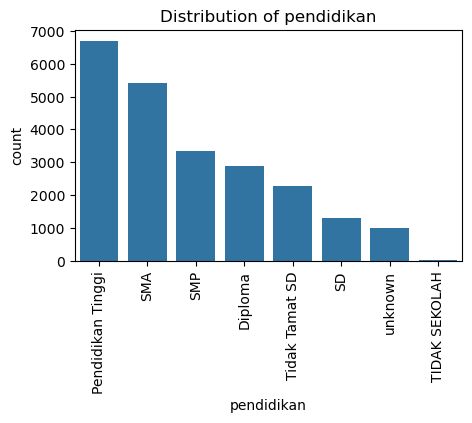

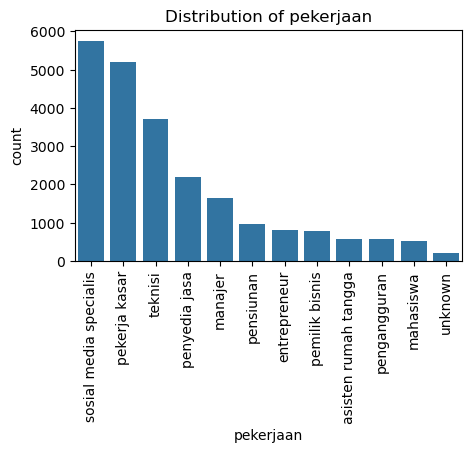

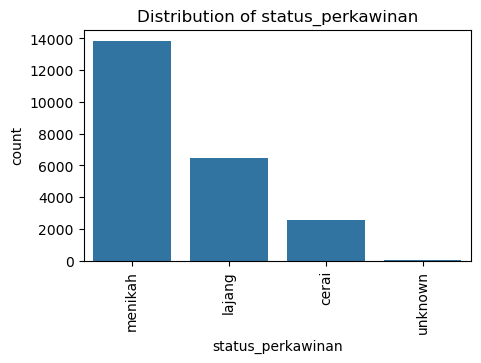

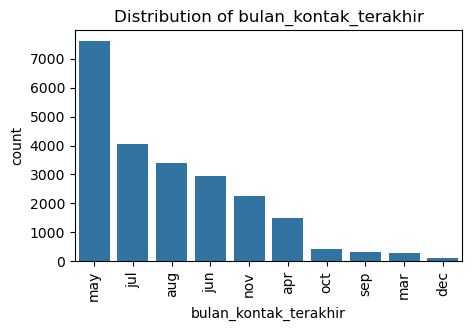

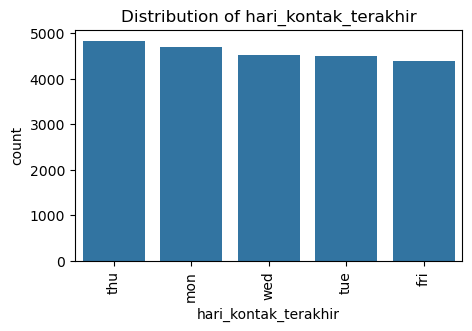

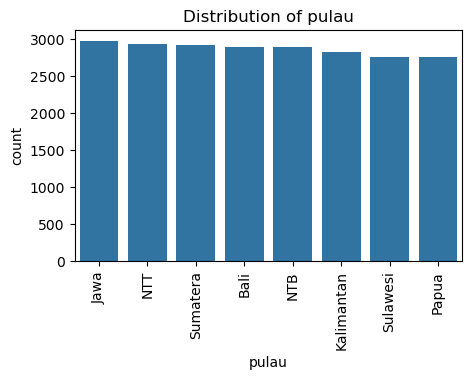

In [149]:
print("Unique Value pendidikan:", train['pendidikan'].unique())
print("Unique Value pekerjaan:", train['pekerjaan'].unique())
print("Unique Value status_perkawinan:", train['status_perkawinan'].unique())
print("Unique Value bulan_kontak_terakhir:", train['bulan_kontak_terakhir'].unique())
print("Unique Value hari_kontak_terakhir:", train['hari_kontak_terakhir'].unique())
print("Unique Value pulau:", train['pulau'].unique())

# Lookin the distribution of each categorical variable
def plot_categorical_distribution(df, column):
    plt.figure(figsize=(5, 3))
    sns.countplot(data=df, x=column, order=df[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=90)
    plt.show()

plot_categorical_distribution(train, 'pendidikan')
plot_categorical_distribution(train, 'pekerjaan')
plot_categorical_distribution(train, 'status_perkawinan')
plot_categorical_distribution(train, 'bulan_kontak_terakhir')
plot_categorical_distribution(train, 'hari_kontak_terakhir')
plot_categorical_distribution(train, 'pulau')

Merubah semua kategori unknown menjadi NaN

In [150]:
# Replace unknown values with NaN
train['pendidikan'] = train['pendidikan'].replace(['unknown'], np.nan)
train['pekerjaan'] = train['pekerjaan'].replace(['unknown'], np.nan)
train['status_perkawinan'] = train['status_perkawinan'].replace(['unknown'], np.nan)
train['gagal_bayar_sebelumnya'] = train['gagal_bayar_sebelumnya'].replace(['unknown'], np.nan)
train['pinjaman_rumah'] = train['pinjaman_rumah'].replace(['unknown'], np.nan)
train['pinjaman_pribadi'] = train['pinjaman_pribadi'].replace(['unknown'], np.nan)
train['pinjaman_pribadi'] = train['pinjaman_pribadi'].replace(['unknown'], np.nan)

test['pendidikan'] = test['pendidikan'].replace(['unknown'], np.nan)
test['pekerjaan'] = test['pekerjaan'].replace(['unknown'], np.nan)
test['status_perkawinan'] = test['status_perkawinan'].replace(['unknown'], np.nan)
test['gagal_bayar_sebelumnya'] = test['gagal_bayar_sebelumnya'].replace(['unknown'], np.nan)
test['pinjaman_rumah'] = test['pinjaman_rumah'].replace(['unknown'], np.nan)
test['pinjaman_pribadi'] = test['pinjaman_pribadi'].replace(['unknown'], np.nan)

# Replace 999 with 0
train['hari_sejak_kontak_sebelumnya'] = train['hari_sejak_kontak_sebelumnya'].replace([999], 0)
test['hari_sejak_kontak_sebelumnya'] = test['hari_sejak_kontak_sebelumnya'].replace([999], 0)

In [151]:
print("Missing values in training dataset:")
print(train.isna().sum())
print("Duplicate rows in training dataset:")
print(train.duplicated().sum())

Missing values in training dataset:
usia                               0
pekerjaan                        193
status_perkawinan                 47
pendidikan                       992
gagal_bayar_sebelumnya          4745
pinjaman_rumah                   579
pinjaman_pribadi                 579
jenis_kontak                       0
bulan_kontak_terakhir              0
hari_kontak_terakhir               0
jumlah_kontak_kampanye_ini         0
hari_sejak_kontak_sebelumnya       0
jumlah_kontak_sebelumnya           0
hasil_kampanye_sebelumnya          0
tingkat_variasi_pekerjaan          0
indeks_harga_konsumen              0
indeks_kepercayaan_konsumen        0
suku_bunga_euribor_3bln            0
jumlah_pekerja                     0
pulau                              0
berlangganan_deposito              0
dtype: int64
Duplicate rows in training dataset:
78


In [152]:
print("\nMissing values in validation dataset:")
print(test.isna().sum())
print("Duplicate rows in validation dataset:")
print(test.duplicated().sum())


Missing values in validation dataset:
usia                               0
pekerjaan                         49
status_perkawinan                  9
pendidikan                       218
gagal_bayar_sebelumnya          1207
pinjaman_rumah                   125
pinjaman_pribadi                 125
jenis_kontak                       0
bulan_kontak_terakhir              0
hari_kontak_terakhir               0
jumlah_kontak_kampanye_ini         0
hari_sejak_kontak_sebelumnya       0
jumlah_kontak_sebelumnya           0
hasil_kampanye_sebelumnya          0
tingkat_variasi_pekerjaan          0
indeks_harga_konsumen              0
indeks_kepercayaan_konsumen        0
suku_bunga_euribor_3bln            0
jumlah_pekerja                     0
pulau                              0
dtype: int64
Duplicate rows in validation dataset:
7


Outliers checking

In [153]:
# Check for numerical columns 
num_cols = train.select_dtypes(include=['int64', 'float64']).columns

print("Numerical columns in training dataset:", num_cols)

Numerical columns in training dataset: Index(['usia', 'jumlah_kontak_kampanye_ini', 'hari_sejak_kontak_sebelumnya',
       'jumlah_kontak_sebelumnya', 'tingkat_variasi_pekerjaan',
       'indeks_harga_konsumen', 'indeks_kepercayaan_konsumen',
       'suku_bunga_euribor_3bln', 'jumlah_pekerja', 'berlangganan_deposito'],
      dtype='object')


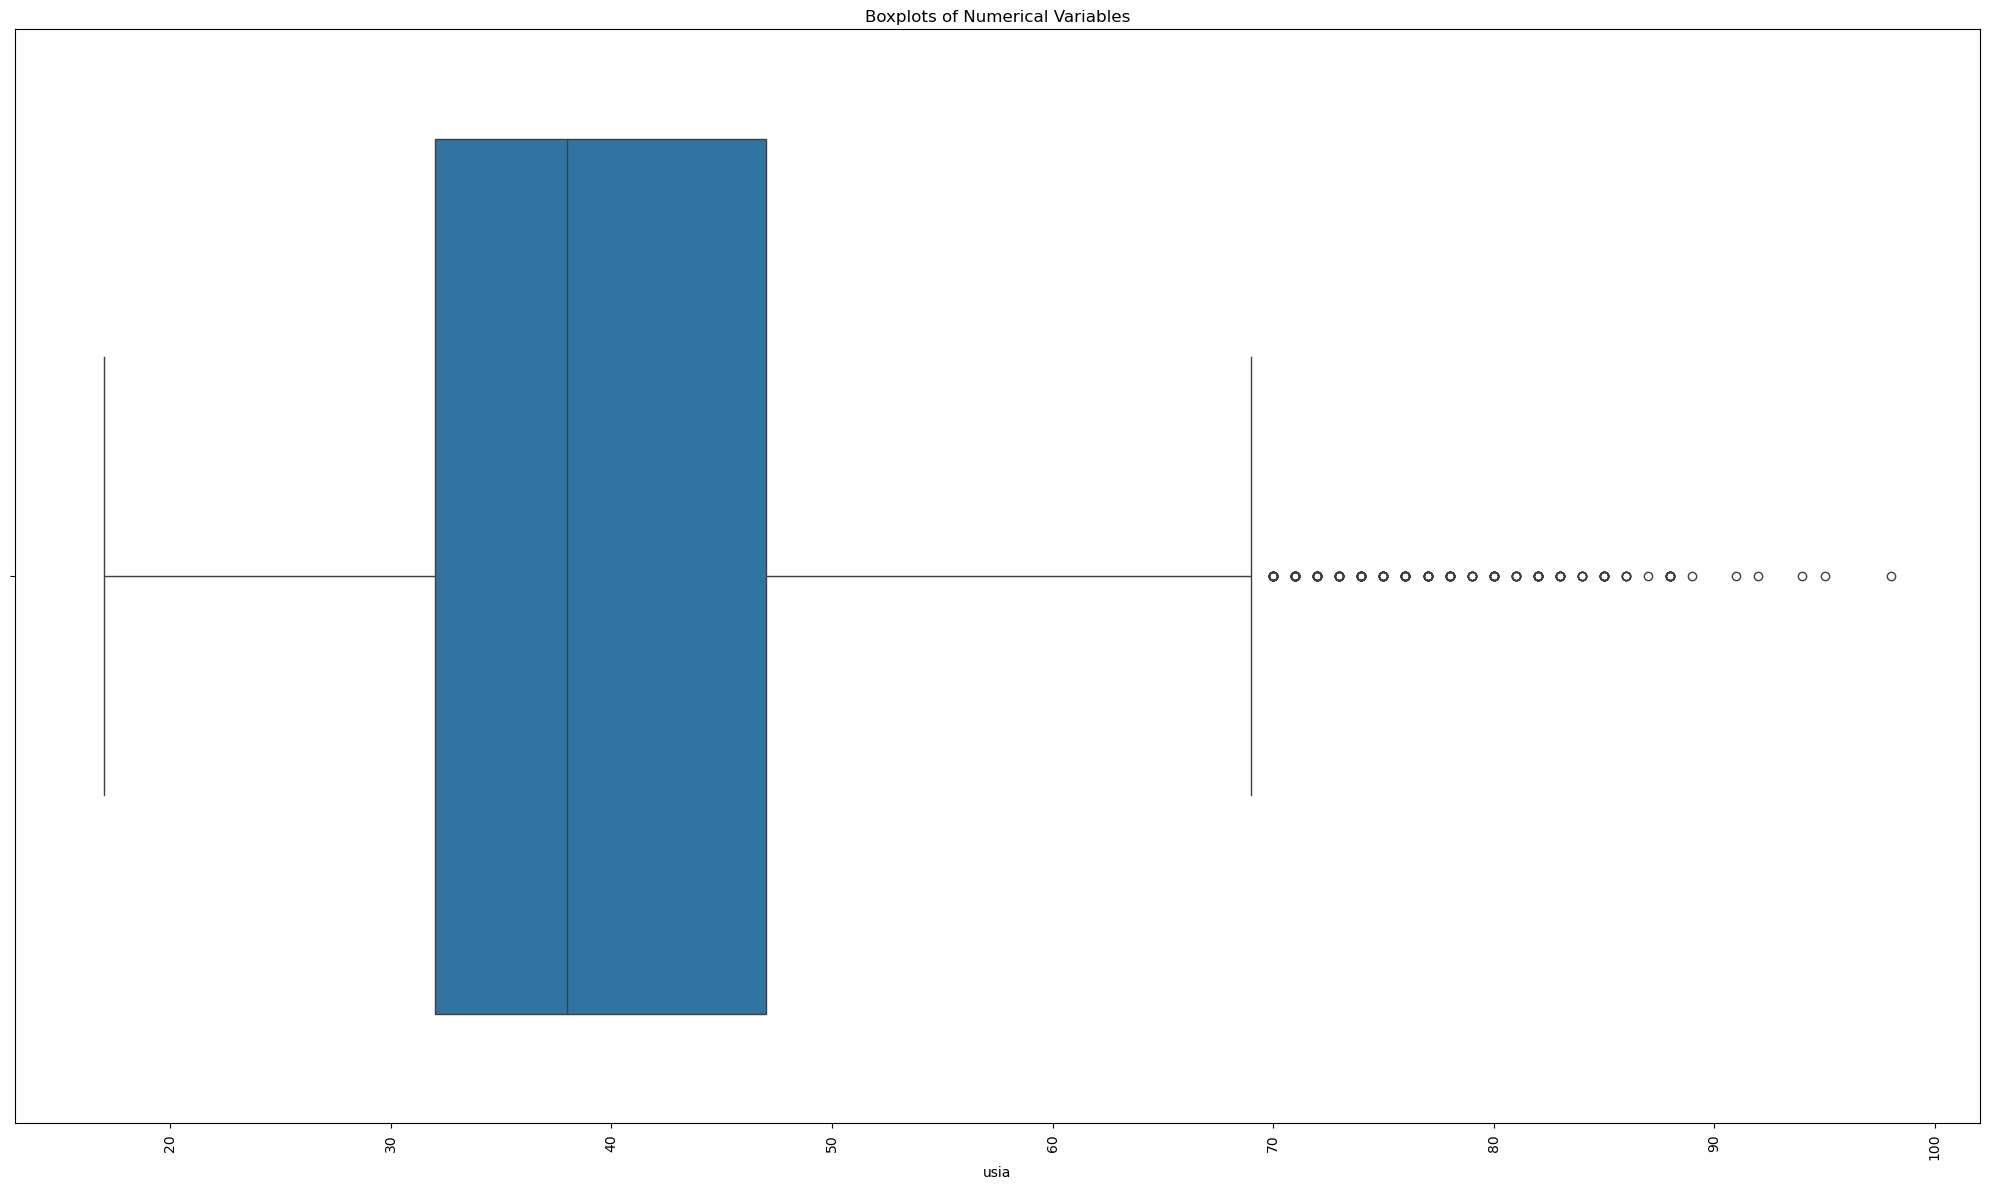

In [154]:
# Create a figure with a larger size for all numerical columns
plt.figure(figsize=(20, 12))

# Create a boxplot for each numerical column
sns.boxplot(data=train['usia'], orient='h')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add a title
plt.title('Boxplots of Numerical Variables')

# Adjust layout
plt.tight_layout()

In [155]:
# # Threshold atas
# def replace_values_above_threshold(data_train, column, threshold):
#     sns.boxplot(data_train[column])
#     plt.title(f'Original Box Plot of {column}')
#     plt.show()

#     above_threshold = data_train[column] > threshold
#     data_train.loc[above_threshold, column] = threshold

#     sns.boxplot(data_train[column])
#     plt.title(f'Box Plot with Values Replaced above {threshold}')
#     plt.show()

#     return train

# train = replace_values_above_threshold(train, 'usia', 68)

# Preprocessing

In [156]:
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
print("Duplicate rows in training dataset after removal:")
print(train.duplicated().sum())
print("Duplicate rows in validation dataset after removal:")
print(test.duplicated().sum())

Duplicate rows in training dataset after removal:
0
Duplicate rows in validation dataset after removal:
0


## Encoding

In [157]:
le = LabelEncoder()

# One-hot encoding for categorical variables
def one_hot_encode(df, columns):
    return pd.get_dummies(df, columns=columns)

# Label pekerjaan
def label_encode(df, column):
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    return df


# Mapping Ordinal Columns
pendidikan_mapping = {
    'TIDAK SEKOLAH': 0,
    'Tidak Tamat SD': 1,
    'SD': 2,
    'SMP': 3,
    'SMA': 4,
    'Diploma': 5,
    'Pendidikan Tinggi': 6,
}

bulan_kontak_mapping = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

hasil_mapping = {
    'failure': -1,
    'nonexistent': 0,
    'success': 1,
}

hari_kontak_mapping = {
    'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5
}

binary_mapping = {
    'yes': 1,
    'no': 0
}

train['pendidikan'] = train['pendidikan'].map(pendidikan_mapping)
test['pendidikan'] = test['pendidikan'].map(pendidikan_mapping)

train['bulan_kontak_terakhir'] = train['bulan_kontak_terakhir'].map(bulan_kontak_mapping)
test['bulan_kontak_terakhir'] = test['bulan_kontak_terakhir'].map(bulan_kontak_mapping)

train['hasil_kampanye_sebelumnya'] = train['hasil_kampanye_sebelumnya'].map(hasil_mapping)
test['hasil_kampanye_sebelumnya'] = test['hasil_kampanye_sebelumnya'].map(hasil_mapping)

train['hari_kontak_terakhir'] = train['hari_kontak_terakhir'].map(hari_kontak_mapping)
test['hari_kontak_terakhir'] = test['hari_kontak_terakhir'].map(hari_kontak_mapping)

train[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumnya']] = train[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumnya']].replace(binary_mapping)
test[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumnya']] = test[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumnya']].replace(binary_mapping)

train = one_hot_encode(train, ['pulau', 'jenis_kontak', 'status_perkawinan', 'pekerjaan'])
test = one_hot_encode(test, ['pulau', 'jenis_kontak', 'status_perkawinan', 'pekerjaan'])

# train = label_encode(train, 'pekerjaan')
# test = label_encode(test, 'pekerjaan')

train = train.astype('float32')
test = test.astype('float32')

C:\Users\asus0\AppData\Local\Temp\ipykernel_17356\2402749609.py:57: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumnya']] = train[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumnya']].replace(binary_mapping)
C:\Users\asus0\AppData\Local\Temp\ipykernel_17356\2402749609.py:58: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumnya']] = test[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumn

In [158]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22838 entries, 0 to 22837
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   usia                              22838 non-null  float32
 1   pendidikan                        21846 non-null  float32
 2   gagal_bayar_sebelumnya            18104 non-null  float32
 3   pinjaman_rumah                    22259 non-null  float32
 4   pinjaman_pribadi                  22259 non-null  float32
 5   bulan_kontak_terakhir             22838 non-null  float32
 6   hari_kontak_terakhir              22838 non-null  float32
 7   jumlah_kontak_kampanye_ini        22838 non-null  float32
 8   hari_sejak_kontak_sebelumnya      22838 non-null  float32
 9   jumlah_kontak_sebelumnya          22838 non-null  float32
 10  hasil_kampanye_sebelumnya         22838 non-null  float32
 11  tingkat_variasi_pekerjaan         22838 non-null  float32
 12  inde

In [159]:
train

,usia,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,bulan_kontak_terakhir,hari_kontak_terakhir,jumlah_kontak_kampanye_ini,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,...,pekerjaan_entrepreneur,pekerjaan_mahasiswa,pekerjaan_manajer,pekerjaan_pekerja kasar,pekerjaan_pemilik bisnis,pekerjaan_pengangguran,pekerjaan_pensiunan,pekerjaan_penyedia jasa,pekerjaan_sosial media specialis,pekerjaan_teknisi
0,63.0,6.0,0.0,1.0,0.0,7.0,5.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,43.0,6.0,0.0,1.0,0.0,11.0,5.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,29.0,6.0,0.0,1.0,1.0,7.0,4.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,40.0,4.0,0.0,0.0,0.0,5.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,40.0,6.0,0.0,0.0,0.0,8.0,3.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22833,32.0,5.0,0.0,1.0,0.0,8.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22834,30.0,5.0,0.0,0.0,0.0,9.0,2.0,2.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22835,29.0,4.0,0.0,1.0,0.0,7.0,3.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22836,52.0,1.0,NaN,1.0,0.0,6.0,1.0,2.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Handling missing values

### Dropping

In [160]:
train_dropped = train.dropna(axis=0, how='any')
print("\nTraining dataset after dropping rows with missing values:")
print(f'Ukuran dataset sebelum drop: {train.shape} dan ukuran dataset setelah drop: {train_dropped.shape}')

test_dropped = test.dropna(axis=0, how='any')
print("\nValidation dataset after dropping rows with missing values:")
print(f'Ukuran dataset sebelum drop: {test.shape} dan ukuran dataset setelah drop: {test_dropped.shape}')


Training dataset after dropping rows with missing values:
Ukuran dataset sebelum drop: (22838, 41) dan ukuran dataset setelah drop: (16982, 41)

Validation dataset after dropping rows with missing values:
Ukuran dataset sebelum drop: (5722, 40) dan ukuran dataset setelah drop: (4278, 40)


### MICE

In [161]:
mice = IterativeImputer(random_state=42)

train_imputed = mice.fit_transform(train)
test_imputed = mice.fit_transform(test)

train_imputed = pd.DataFrame(train_imputed, columns=train.columns)
test_imputed = pd.DataFrame(test_imputed, columns=test.columns)

# Splitting

In [162]:
X = train_dropped.drop(columns=['berlangganan_deposito'])
y = train_dropped['berlangganan_deposito']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling

In [163]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

# Resampling

## Over under

In [164]:
# # OVER UNDER

# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler

# # Inisialisasi undersampler untuk kelas 0
# undersampler = RandomUnderSampler(sampling_strategy={0: 5000}, random_state=42)
# # Inisialisasi oversampler untuk kelas 1 dan 2
# oversampler = RandomOverSampler(sampling_strategy={1: 2000, 0: 5000}, random_state=42)

# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# X_train_final, y_train_final = oversampler.fit_resample(X_train_resampled, y_train_resampled)

# from collections import Counter
# print("Distribusi kelas setelah resampling:", Counter(y_train_final['coppaRisk']))

# X_train = X_train_final
# y_train = y_train_final

## SMOTE

In [165]:
# smote = SMOTE(random_state=42, sampling_strategy='auto')
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
# X_val_resampled, y_val_resampled = smote.fit_resample(X_val_scaled, y_val)
# print("Distribusi kelas setelah SMOTE:")
# print(Counter(y_train_resampled))
# X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
# X_val_resampled = pd.DataFrame(X_val_resampled, columns=X_val.columns)

# Modelling

## Training

In [166]:
# Train the model
model1 = XGBClassifier(objective="binary:logistic", eval_metric="auc", random_state=42)
model1.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], verbose=True)

[0]	validation_0-auc:0.81102
[1]	validation_0-auc:0.81825


[2]	validation_0-auc:0.82232
[3]	validation_0-auc:0.82006
[4]	validation_0-auc:0.82206
[5]	validation_0-auc:0.82355
[6]	validation_0-auc:0.82272
[7]	validation_0-auc:0.82365
[8]	validation_0-auc:0.82155
[9]	validation_0-auc:0.82233
[10]	validation_0-auc:0.82368
[11]	validation_0-auc:0.82453
[12]	validation_0-auc:0.82430
[13]	validation_0-auc:0.82309
[14]	validation_0-auc:0.82467
[15]	validation_0-auc:0.82334
[16]	validation_0-auc:0.82282
[17]	validation_0-auc:0.82474
[18]	validation_0-auc:0.82424
[19]	validation_0-auc:0.82395
[20]	validation_0-auc:0.82424
[21]	validation_0-auc:0.82281
[22]	validation_0-auc:0.82305
[23]	validation_0-auc:0.82266
[24]	validation_0-auc:0.82284
[25]	validation_0-auc:0.82194
[26]	validation_0-auc:0.82191
[27]	validation_0-auc:0.82044
[28]	validation_0-auc:0.82150
[29]	validation_0-auc:0.82182
[30]	validation_0-auc:0.81934
[31]	validation_0-auc:0.81775
[32]	validation_0-auc:0.81812
[33]	validation_0-auc:0.81794
[34]	validation_0-auc:0.81773
[35]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

<Figure size 1000x800 with 0 Axes>

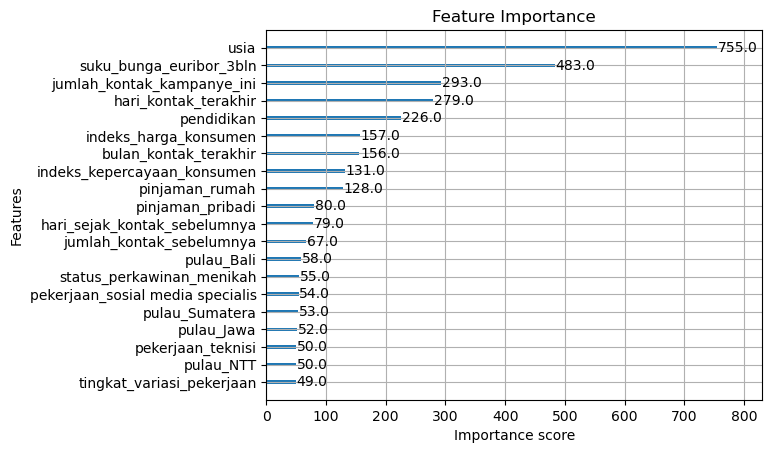

In [167]:
from xgboost import plot_importance
plt.figure(figsize=(10, 8))
plot_importance(model1, max_num_features=20, importance_type='weight', title='Feature Importance')
plt.show()

## Evaluating

Accuracy: 0.8846
ROC AUC Score: 0.7969

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      2961
         1.0       0.59      0.33      0.43       436

    accuracy                           0.88      3397
   macro avg       0.75      0.65      0.68      3397
weighted avg       0.87      0.88      0.87      3397


Confusion Matrix:
[[2860  101]
 [ 291  145]]


<Axes: >

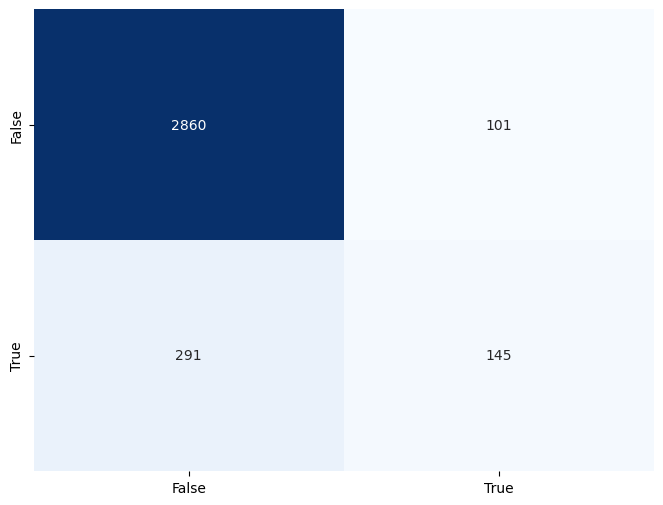

In [168]:
# Make predictions
y_pred = model1.predict(X_val_scaled)
y_pred_proba = model1.predict_proba(X_val_scaled)[:,1]

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)
conf_matrix = confusion_matrix(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("\nConfusion Matrix:")
print(conf_matrix)

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['False', 'True'], yticklabels=['False', 'True'])
